# Process rosbag and plot for ICRA 2021 video submission

In [1]:
# Auto Reload Modules
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.signal import lfilter

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rc, font_manager, transforms
from matplotlib.ticker import FormatStrFormatter

from bag_utils import extract_traj
from plot_utils import plot_map_2d, plot_map_3d, plot_car_frames

import os
notebook_dir = str(os.getcwd())

DATA_DIR = '/data/barc_data/successful_runs_11_01'

# Ouput directory
OUT_DIR = os.path.join(notebook_dir, 'plot_out')
if not os.path.isdir(OUT_DIR):
    os.mkdir(OUT_DIR)
    
np.random.seed(0)

map_bounds = [0, 6, -1, 1]

rc('font', **{'family': "Times New Roman"})

### Load bag and extract data

In [2]:
import glob
bag_files = glob.glob(os.path.join(DATA_DIR,'*.bag'))
print('Found bags:', bag_files)

Found bags: ['/data/barc_data/successful_runs_11_01/barc_run_strategy_obca_2020-11-01-16-59-53_exp_10.bag']


In [3]:
from bag_utils import VideoDataReader

bag_num = 0
bag_name = bag_files[bag_num]
param_dir = bag_name.split('.')[0]

vid_reader = VideoDataReader(bag_name, param_dir)

Video of duration 51.0398 s read in as 1275 frames


### Set transformation parameters between camera image pixels and global position

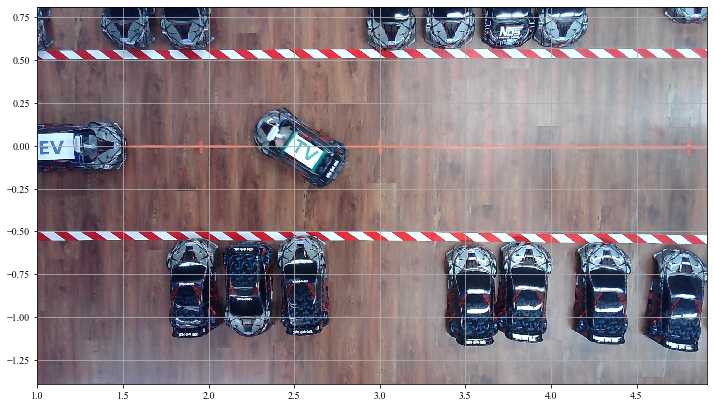

In [4]:
frame_num = 700
image, t, frame_num, data = vid_reader.get_frame(frame_idx=frame_num)
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

image_ratio = image.shape[1]/image.shape[0]
image_height = 2.2 # in meters
image_bot_coord = -1.39
image_width = image_height * image_ratio
image_left_coord = 1
image_y_coords = np.array([image_bot_coord, image_bot_coord+image_height])
image_x_coords = np.array([image_left_coord, image_left_coord+image_width])
ax.imshow(image, extent=(image_x_coords[0],image_x_coords[1],image_y_coords[0],image_y_coords[1]))
plt.grid(b=True)

### Single frame plotting example

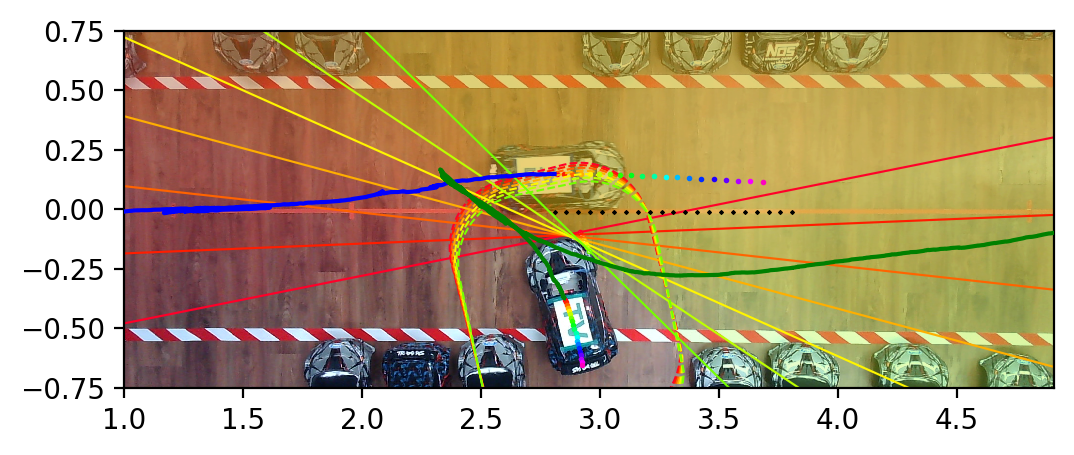

In [31]:
import matplotlib
from matplotlib.transforms import Affine2D

shade_hyp = True
frame_num = 1000
image, t, frame_num, data = vid_reader.get_frame(frame_idx=frame_num)

# time = 15.4
# image, t, frame_num, data = vid_reader.get_frame(time=time)

EV_x_offset = -0.05
EV_y_offset = -0.01
TV_x_offset = 0.0
TV_y_offset = 0.0

EV_L = vid_reader.EV_L + 0.05
EV_W = vid_reader.EV_W
TV_L = vid_reader.TV_L + 0.05
TV_W = vid_reader.TV_W

N = vid_reader.N
c = [matplotlib.cm.get_cmap('gist_rainbow')(i*(1./(N-1))) for i in range(N)]

image_ratio = image.shape[1]/image.shape[0]
image_y = np.array([-1.25, 0.7])
image_x = (image_y[1]-image_y[0])*image_ratio + 1.0

EV_car = matplotlib.patches.Rectangle((-0.5*EV_L,-0.5*EV_W), EV_L, EV_W, color='blue', alpha=0.3)
TV_car = matplotlib.patches.Rectangle((-0.5*TV_L,-0.5*TV_W), TV_L, TV_W, color='green', alpha=0.3)

traj_fig = plt.figure(dpi=200)
traj_ax = traj_fig.gca()
traj_ax.imshow(image, extent=(image_x_coords[0],image_x_coords[1],image_y_coords[0],image_y_coords[1]))

# traj_ax.add_patch(EV_car)
# EV_car.set_xy((data['ev_state'][-1,0]+EV_x_offset-EV_L/2, data['ev_state'][-1,1]+EV_y_offset-EV_W/2))
# R = Affine2D().rotate_around(data['ev_state'][-1,0]+EV_x_offset, data['ev_state'][-1,1]+EV_y_offset, data['ev_state'][-1,2]) + traj_ax.transData
# EV_car.set_transform(R)

# traj_ax.add_patch(TV_car)
# TV_car.set_xy((data['tv_state'][-1,0]+TV_x_offset-TV_L/2, data['tv_state'][-1,1]+TV_y_offset-TV_W/2))
# R = Affine2D().rotate_around(data['tv_state'][-1,0]+TV_x_offset, data['tv_state'][-1,1]+TV_y_offset, data['tv_state'][-1,2]) + traj_ax.transData
# TV_car.set_transform(R)

for i in range(N):
    if data['crit_region'][i]:
        traj_ax.plot(data['coll_bound'][i][:,0] + TV_x_offset, data['coll_bound'][i][:,1] + TV_y_offset, '--', c=c[i], linewidth=0.75)
        traj_ax.plot(data['hyp'][i]['pos'][0] + TV_x_offset, data['hyp'][i]['pos'][1] + TV_y_offset, 'o', c=c[i], markersize=1.5, markeredgecolor=c[i], markerfacecolor='w', markeredgewidth=0.5)
        hyp_x = np.array(map_bounds[:2])
        hyp_y = (-data['hyp'][i]['w'][0]*hyp_x+data['hyp'][i]['b'])/data['hyp'][i]['w'][1]
        traj_ax.plot(hyp_x + TV_x_offset, hyp_y + TV_y_offset, c=c[i], linewidth=0.75)
        
        if shade_hyp:
            if np.argmax(data['score'][-1]) == 0:
                fill_y = np.array([1, 1])
            elif np.argmax(data['score'][-1]) == 1:
                fill_y = np.array([-1, -1])
                
            traj_ax.fill_between(hyp_x, hyp_y, fill_y, color=c[i], alpha=0.1)
            
    traj_ax.plot(data['ev_pred'][i,0] + EV_x_offset, data['ev_pred'][i,1] + EV_y_offset, 'o', c=c[i], markersize=1)
    traj_ax.plot(data['tv_pred'][i,0] + TV_x_offset, data['tv_pred'][i,1] + TV_y_offset, 'o', c=c[i], markersize=1)


traj_ax.plot(data['ev_state'][:,0] + EV_x_offset, data['ev_state'][:,1] + EV_y_offset, linewidth=1.5, color='b', label="EV", zorder=5)
traj_ax.plot(data['ev_ref'][:,0] + EV_x_offset, data['ev_ref'][:,1] + EV_y_offset, 'kx', markersize=1)
traj_ax.plot(data['tv_state'][:,0] + TV_x_offset, data['tv_state'][:,1] + TV_y_offset, linewidth=1.5, color='g', label="TV", zorder=5)

traj_ax.set_xlim(image_x_coords)
traj_ax.set_ylim([-0.75, 0.75])
traj_ax.set_aspect('equal')

plt.draw()
plt.show()

fig_name = os.path.join(OUT_DIR, 'video_overlay' + str(frame_num) + '.png')
traj_fig.savefig(fig_name, transparent=True)

### Plot all frames

In [ ]:
import matplotlib

for frame_num in range(vid_reader.n_frames):
    image, t, frame_num, data = vid_reader.get_frame(frame_idx=frame_num)

    # time = 15.4
    # image, t, frame_num, data = vid_reader.get_frame(time=time)

    EV_x_offset = -0.1
    EV_y_offset = 0.0
    TV_x_offset = -0.05
    TV_y_offset = 0.0

    N = vid_reader.N
    c = [matplotlib.cm.get_cmap('gist_rainbow')(i*(1./(N-1))) for i in range(N)]

    image_ratio = image.shape[1]/image.shape[0]
    image_y = np.array([-1.25, 0.7])
    image_x = (image_y[1]-image_y[0])*image_ratio + 1.0

    traj_fig = plt.figure(dpi=200)
    traj_ax = traj_fig.gca()
    traj_ax.imshow(image, extent=(image_x_coords[0],image_x_coords[1],image_y_coords[0],image_y_coords[1]))

    for i in range(N):
        if data['crit_region'][i]:
            traj_ax.plot(data['coll_bound'][i][:,0] + TV_x_offset, data['coll_bound'][i][:,1] + TV_y_offset, '--', c=c[i], linewidth=0.75)
            traj_ax.plot(data['hyp'][i]['pos'][0] + TV_x_offset, data['hyp'][i]['pos'][1] + TV_y_offset, 'o', c=c[i], markersize=1.5, markeredgecolor=c[i], markerfacecolor='w', markeredgewidth=0.5)
            hyp_x = np.array(map_bounds[:2])
            hyp_y = (-data['hyp'][i]['w'][0]*hyp_x+data['hyp'][i]['b'])/data['hyp'][i]['w'][1]
            traj_ax.plot(hyp_x + TV_x_offset, hyp_y + TV_y_offset, c=c[i], linewidth=0.75)
        traj_ax.plot(data['ev_pred'][i,0] + EV_x_offset, data['ev_pred'][i,1] + EV_y_offset, 'o', c=c[i], markersize=1)
        traj_ax.plot(data['tv_pred'][i,0] + TV_x_offset, data['tv_pred'][i,1] + TV_y_offset, 'o', c=c[i], markersize=1)


    traj_ax.plot(data['ev_state'][:,0] + EV_x_offset, data['ev_state'][:,1] + EV_y_offset, linewidth=1.5, color='b', label="EV", zorder=5)
    traj_ax.plot(data['ev_ref'][:,0] + EV_x_offset, data['ev_ref'][:,1] + EV_y_offset, 'kx', markersize=1)
    traj_ax.plot(data['tv_state'][:,0] + TV_x_offset, data['tv_state'][:,1] + TV_y_offset, linewidth=1.5, color='g', label="TV", zorder=5)
    traj_ax.set_xlim(image_x_coords)
    traj_ax.set_ylim([-0.75, 0.75])
    traj_ax.set_aspect('equal')

    plt.draw()
#     plt.show()

    fig_name = os.path.join(OUT_DIR, 'video_overlay' + str(frame_num) + '.png')
    traj_fig.savefig(fig_name, transparent=True)
    traj_fig.close()

### Plot trajectory trace with axis labels

In [ ]:
ev_traj_fig = plt.figure('ev_trajectory_trace', dpi=200)
ev_traj_ax = ev_traj_fig.gca()

ev_traj_ax.plot(data['ev_state'][:,0], data['ev_state'][:,1], linewidth=1.5, color='b', label="EV", zorder=5)
ev_traj_ax.set_xlim(map_bounds[:2])
ev_traj_ax.set_ylim(map_bounds[2:])
ev_traj_ax.set_aspect('equal')


tv_traj_fig = plt.figure('tv_trajectory_trace', dpi=200)
tv_traj_ax = tv_traj_fig.gca()

tv_traj_ax.plot(data['tv_state'][:,0], data['tv_state'][:,1], linewidth=1.5, color='g', label="TV", zorder=5)
tv_traj_ax.set_xlim(map_bounds[:2])
tv_traj_ax.set_ylim(map_bounds[2:])
tv_traj_ax.set_aspect('equal')

plt.draw()
plt.show()

fig_name = os.path.join(OUT_DIR, 'ev_traj_trace_axis_frame_' + str(frame_num) + '.png')
ev_traj_fig.savefig(fig_name, transparent=True)
fig_name = os.path.join(OUT_DIR, 'tv_traj_trace_axis_frame_' + str(frame_num) + '.png')
tv_traj_fig.savefig(fig_name, transparent=True)

### Plot trajectory trace without axis labels

In [ ]:
ev_traj_fig = plt.figure('ev_trajectory_trace', dpi=200)
ev_traj_ax = ev_traj_fig.gca()

ev_traj_ax.plot(data['ev_state'][:,0], data['ev_state'][:,1], linewidth=1.5, color='b', label="EV", zorder=5)
ev_traj_ax.set_xlim(map_bounds[:2])
ev_traj_ax.set_ylim(map_bounds[2:])
ev_traj_ax.set_aspect('equal')
ev_traj_ax.axis('off')

tv_traj_fig = plt.figure('tv_trajectory_trace', dpi=200)
tv_traj_ax = tv_traj_fig.gca()

tv_traj_ax.plot(data['tv_state'][:,0], data['tv_state'][:,1],, linewidth=1.5, color='g', label="TV", zorder=5)
tv_traj_ax.set_xlim(map_bounds[:2])
tv_traj_ax.set_ylim(map_bounds[2:])
tv_traj_ax.set_aspect('equal')
tv_traj_ax.axis('off')

plt.draw()
plt.show()

fig_name = os.path.join(OUT_DIR, 'ev_traj_trace_axis_frame_' + str(frame_num) + '.png')
ev_traj_fig.savefig(fig_name, transparent=True)
fig_name = os.path.join(OUT_DIR, 'tv_traj_trace_axis_frame_' + str(frame_num) + '.png')
tv_traj_fig.savefig(fig_name, transparent=True)

### Plot States and Inputs

In [ ]:
fig = plt.figure('state_inputs', figsize=(12, 7), dpi=200)

# ================= Speed Subplot
ax_speed = plt.subplot(3, 1, 1)

# Filtering
n = 20
b = [1.0 / n] * n
a = 1

strat_v_filter = lfilter(b, a, data['ev_state'][:,3])

t_strat = data['ev_state_t'] - data['ev_state_t'][0]
ax_speed.plot(t_strat, strat_v_filter, linewidth=5, color='b', label="SG")

ax_speed.set_ylabel("Speed\n(m/s)", fontsize=25, fontweight="bold")
ax_speed.set_xlim(left=0, right=30)
ax_speed.set_ylim(bottom=-0.6, top=0.6)

ax_speed.set_yticks([-0.5, -0.25, 0, 0.25, 0.5])
ax_speed.tick_params(axis='y', labelsize=20)
ax_speed.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax_speed.tick_params(axis='x', bottom=False, labelbottom=False)

# ================== Input subplot

# Delta
ax_delta = plt.subplot(3, 1, 2)

t_strat = data['ev_input_t'] - data['ev_input_t'][0]
ax_delta.plot(t_strat, data['ev_input'][:,0], linewidth=5, color='b', label="SG")

ax_delta.set_ylabel("Steering\n(rad)", fontsize=25, fontweight="bold")
ax_delta.set_xlim(left=0, right=30)
ax_delta.set_ylim(bottom=-0.6, top=0.6)

ax_delta.set_yticks([-0.5, -0.25, 0, 0.25, 0.5])
ax_delta.tick_params(axis='y', labelsize=20)
ax_delta.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax_delta.tick_params(axis='x', bottom=False, labelbottom=False)

# Acc
ax_acc = plt.subplot(3, 1, 3)

ax_acc.plot(t_strat, data['ev_input'][:,1], linewidth=5, color='b', label="SG")

ax_acc.set_xlabel("Time (s)", fontsize=25, fontweight="bold")
ax_acc.set_ylabel("Accel\n(m/s$^2$)", fontsize=25, fontweight="bold")

ax_acc.set_xlim(left=0, right=30)
ax_acc.set_ylim(bottom=-1.2, top=1.2)


ax_acc.set_yticks([-1, -0.5, 0, 0.5, 1])
ax_acc.tick_params(axis='y', labelsize=20)
ax_acc.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax_acc.tick_params(axis='x', labelsize=20)

plt.subplots_adjust(hspace=0.1)
plt.tight_layout()


### Plot Score and FSM

In [ ]:
fig = plt.figure('score_fsm', figsize=(12, 6), dpi=200)

# ================= Score Subplot
ax_score = plt.subplot(2, 1, 1)

t_strat = data['score_t'] - data['score_t'][0]
ax_score.plot(t_strat, data['score'][:,0], linewidth=5, color='m', linestyle='solid', label="Pass Left")
ax_score.plot(t_strat, data['score'][:,1], linewidth=5, color='c', linestyle='dashed', label="Pass Right")
ax_score.plot(t_strat, data['score'][:,2], linewidth=5, color='r', linestyle='dashdot', label="Yield")

ax_score.set_xlim([0, 16])
ax_score.set_ylim([-0.02, 1.02])

ax_score.set_ylabel("Confidence", labelpad=40, fontsize=25, fontweight="bold")

ax_score.tick_params(axis='y', labelsize=20)

ax_score.tick_params(axis='x', bottom=False, labelbottom=False)

ax_score.grid(axis='y')

ax_score.legend(fontsize=20)

# ================== Policy subplot

ax_policy = plt.subplot(2, 1, 2)

t_strat = data['fsm_t'] - data['fsm_t'][0]
ax_policy.plot(t_strat, data['fsm'], linewidth=5, color='C1', label="SG")

ax_policy.set_xlabel("Time (s)", fontsize=25, fontweight="bold")
ax_policy.set_ylabel("Policy", fontsize=25, fontweight="bold")

ax_policy.set_xlim([0, 20])
ax_policy.set_ylim([-0.5, 2.5])

ax_policy.set_yticks([0, 1, 2])

FSM_strat.state_names = ["SG/BL-\nOBCA", "SC", "EB"]

ax_policy.set_yticklabels(FSM_strat.state_names)
ax_policy.tick_params(axis='y', labelsize=20)

ax_policy.tick_params(axis='x', labelsize=20)

ax_policy.grid(axis='y')

plt.subplots_adjust(hspace=0.01)
plt.tight_layout()


### Plot the state and policy

In [ ]:
fig = plt.figure('state_input_score_policy', figsize=(12, 11), dpi=200)

# ================= Speed Subplot
ax_speed = plt.subplot(5, 1, 1)

# Filtering
n = 20
b = [1.0 / n] * n
a = 1

strat_v_filter = lfilter(b, a, data['ev_state'][:,3])

t_strat = data['ev_state_t'] - data['ev_state_t'][0]
ax_speed.plot(t_strat, strat_v_filter, linewidth=5, color='b', label="SG")

ax_speed.set_ylabel("Speed\n(m/s)", fontsize=25, fontweight="bold")
ax_speed.set_xlim(left=0, right=30)
ax_speed.set_ylim(bottom=-0.6, top=0.6)

ax_speed.set_yticks([-0.5, -0.25, 0, 0.25, 0.5])
ax_speed.tick_params(axis='y', labelsize=20)
ax_speed.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax_speed.tick_params(axis='x', bottom=False, labelbottom=False)

# ================== Input subplot

# Delta
ax_delta = plt.subplot(5, 1, 2)

t_strat = data['ev_input_t'] - data['ev_input_t'][0]
ax_delta.plot(t_strat, data['ev_input'][:,0], linewidth=5, color='b', label="SG")

ax_delta.set_ylabel("Steering\n(rad)", fontsize=25, fontweight="bold")
ax_delta.set_xlim(left=0, right=30)
ax_delta.set_ylim(bottom=-0.6, top=0.6)

ax_delta.set_yticks([-0.5, -0.25, 0, 0.25, 0.5])
ax_delta.tick_params(axis='y', labelsize=20)
ax_delta.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax_delta.tick_params(axis='x', bottom=False, labelbottom=False)

# Acc
ax_acc = plt.subplot(5, 1, 3)

ax_acc.plot(t_strat, data['ev_input'][:,1], linewidth=5, color='b', label="SG")

# ax_acc.set_xlabel("Time (s)", fontsize=25, fontweight="bold")
ax_acc.set_ylabel("Accel\n(m/s$^2$)", fontsize=25, fontweight="bold")

ax_acc.set_xlim(left=0, right=30)
ax_acc.set_ylim(bottom=-1.2, top=1.2)


ax_acc.set_yticks([-1, -0.5, 0, 0.5, 1])
ax_acc.tick_params(axis='y', labelsize=20)
ax_acc.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax_acc.tick_params(axis='x', bottom=False, labelbottom=False)

# ================= Score Subplot
ax_score = plt.subplot(5, 1, 4)

t_strat = data['score_t'] - data['score_t'][0]
ax_score.plot(t_strat, data['score'][:,0], linewidth=5, color='m', linestyle='solid', label="Pass Left")
ax_score.plot(t_strat, data['score'][:,1], linewidth=5, color='c', linestyle='dashed', label="Pass Right")
ax_score.plot(t_strat, data['score'][:,2], linewidth=5, color='r', linestyle='dashdot', label="Yield")

ax_score.set_xlim([0, 16])
ax_score.set_ylim([-0.02, 1.02])

ax_score.set_ylabel("Confidence", labelpad=40, fontsize=25, fontweight="bold")

ax_score.tick_params(axis='y', labelsize=20)

ax_score.tick_params(axis='x', bottom=False, labelbottom=False)

ax_score.grid(axis='y')

ax_score.legend(fontsize=20)

# ================== Policy subplot

ax_policy = plt.subplot(5, 1, 5)

t_strat = data['fsm_t'] - data['fsm_t'][0]
ax_policy.plot(t_strat, data['fsm'], linewidth=5, color='C1', label="SG")

ax_policy.set_xlabel("Time (s)", fontsize=25, fontweight="bold")
ax_policy.set_ylabel("Policy", fontsize=25, fontweight="bold")

ax_policy.set_xlim([0, 20])
ax_policy.set_ylim([-0.5, 2.5])

ax_policy.set_yticks([0, 1, 2])

FSM_strat.state_names = ["SG/BL-\nOBCA", "SC", "EB"]

ax_policy.set_yticklabels(FSM_strat.state_names)
ax_policy.tick_params(axis='y', labelsize=20)

ax_policy.tick_params(axis='x', labelsize=20)

ax_policy.grid(axis='y')

plt.subplots_adjust(hspace=0.1)
plt.tight_layout()
